## Trying out the Fine-tuning of the BART Model

article{DBLP:journals/corr/abs-1910-13461, author = {Mike Lewis and Yinhan Liu and Naman Goyal and Marjan Ghazvininejad and Abdelrahman Mohamed and Omer Levy and Veselin Stoyanov and Luke Zettlemoyer}, title = {{BART:} Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension}, journal = {CoRR}, volume = {abs/1910.13461}, year = {2019}, url = {http://arxiv.org/abs/1910.13461}, eprinttype = {arXiv}, eprint = {1910.13461}, timestamp = {Thu, 31 Oct 2019 14:02:26 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1910-13461.bib}, bibsource = {dblp computer science bibliography, https://dblp.org} }

In [ ]:
!pip install transformers
!pip install huggingface
!pip install accelerate
!pip install rouge_score
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=ef8302e96523c4db1f111f6abfd5bce1605d9234dd90d3612fb57a135a4714e3
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f

In [ ]:
## important all needed packages
import transformers
import huggingface
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from google.colab import drive
from transformers import pipeline
from transformers import DataCollatorForSeq2Seq
from torch.utils.data import DataLoader
import evaluate
from tqdm.auto import tqdm
import torch
import numpy as np
import nltk
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
import matplotlib.pyplot as plt

## further downloads
nltk.download('punkt')
rouge_score = evaluate.load("rouge")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#### functions ####

## Code for all functions to be called in later

def preprocess_function(input):

    """
    This function applies the tokenizer to both
    the descriptons and the names.
    max_input_length: Maximum length of tokens in input (description ) - to be defined globally
    max_target_length: Maximum number of tokens in output (title) - to be defined globally
    """

    model_inputs = tokenizer(
        input["description"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        input["name"], max_length=max_target_length, truncation=True   ## truncate to maximum length
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs




## function to process data so that it can be used in the finetuning


def prepare_data(airbnb_london_filtered_advanced, frac_train_size, batch_size):

  """
  This function prepares the data for the subsequent fine-tuning.
  First Input: Dataset (as loaded from Drive)
  frac_train_size: fraction to be used in training
  batch_size: Batch size to be used in preparing the DataLoaders
  """

  train_eval_airbnb_london_filtered_advanced = airbnb_london_filtered_advanced[airbnb_london_filtered_advanced.in_top_third == 1]

  train_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.sample(n = int(np.ceil(frac_train_size*train_eval_airbnb_london_filtered_advanced.shape[0])), random_state = 100)
  eval_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.drop(train_airbnb_london_filtered_advanced.index, axis = 0)


  ## re-setting the index, else looping through dataloaders results in erros: https://discuss.pytorch.org/t/keyerror-when-enumerating-over-dataloader/54210/8
  train_airbnb_london_filtered_advanced.index = list(range(train_airbnb_london_filtered_advanced.shape[0]))
  eval_airbnb_london_filtered_advanced.index = list(range(eval_airbnb_london_filtered_advanced.shape[0]))


  # tokenized_datasets
  tokenized_datasets  = train_airbnb_london_filtered_advanced.apply(preprocess_function, axis = 1)

  # eval_tokenized_datasets
  eval_tokenized_datasets  = eval_airbnb_london_filtered_advanced.apply(preprocess_function, axis = 1)

  ## calling data loader
  #batch_size = 8

  train_dataloader = DataLoader(
      tokenized_datasets,
      shuffle=True,
      collate_fn=data_collator,
      batch_size=batch_size,
  )

  eval_dataloader = DataLoader(
      eval_tokenized_datasets,
  #   shuffle=True,
      collate_fn=data_collator,
      batch_size=batch_size
  )

  return train_dataloader, eval_dataloader


def postprocess_text(preds, labels):

    """
    Post-processing to prepare inputs to the ROGUE functions
    """
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def preprocess_rogue(input_ids, attention_mask, labels):

  """
  Requires in input_ids and att_masks
  - Model needs to have been called.
  """
  generated_tokens = accelerator.unwrap_model(model).generate(input_ids=input_ids, attention_mask=attention_mask)

  # apply padding
  padded_generated_tokens = accelerator.pad_across_processes( generated_tokens, dim=1, pad_index=tokenizer.pad_token_id)

  # labels to cpu
  labels = labels.cpu().numpy()

  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  if isinstance(padded_generated_tokens, tuple):
    padded_generated_tokens = padded_generated_tokens[0]
  decoded_preds = tokenizer.batch_decode( padded_generated_tokens, skip_special_tokens=True )
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text( decoded_preds, decoded_labels)

  return decoded_preds, decoded_labels





In [ ]:

# connecting to drive
from google.colab import drive
drive.mount('/content/gdrive')


airbnb_london_filtered_advanced = pd.read_csv("/content/gdrive/My Drive/Thesis/London_Data/airbnb_london_filtered_advanced.csv")


Mounted at /content/gdrive


<ipython-input-3-be62042bd4eb>:6: DtypeWarning: Columns (1,3,22,41,45,46,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_london_filtered_advanced = pd.read_csv("/content/gdrive/My Drive/Thesis/London_Data/airbnb_london_filtered_advanced.csv")


### Firstly with BART (trained on CNN)


https://huggingface.co/docs/transformers/main/en/model_doc/bart#transformers.BartForConditionalGeneration

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")


In [ ]:
## preparing the training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
optimizer = AdamW(model.parameters(), lr=2e-5)


#### Train Test Split:

I shall use the top 33% (as measured by the review metric) as the training and evaluation sample as only 'successful' listings should be used for the training.

Furthermore, in the evaluation part, using supposed sucessful listings and their titles means that semantic proximity is measured between the generated titles and 'useful' ones. Measuring the similarity of the evaluation loss given low quality titles would not reveal meaningful information given the task at hand.


In [ ]:
frac_train_size = 0.7
batch_size = 8
max_input_length = 512
max_target_length = 15


train_dataloader, eval_dataloader = prepare_data(airbnb_london_filtered_advanced, frac_train_size, batch_size)


Here, the Huggingface Accelerate method is used.

Accelerate is a python library developed by the Huggingface Team to
automate training and deployment of complex NLP models.

https://huggingface.co/docs/accelerate/index

In [ ]:

accelerator = Accelerator(
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
### Setting up dynamic learning rate scheduler ###

# before the sheduler is called, a few clarifications:

# len(train_dataloader) denotes the amount of batches per training set.
# the var 'num_training_steps' denotes that times the epochs. This is important for the tqdm update bar

# the loss should be saved
   # 1) per training step
   # 2) per epoch


num_train_epochs = 7       ### first only 5 to try out !!


num_update_steps_per_epoch = len(train_dataloader)
num_eval_steps_per_epoch = len(eval_dataloader)

num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,     ## one might also alter this!
    num_training_steps=num_training_steps,
)

In [ ]:
## using GPU

device = 'cuda'
model = model.to(device)

Computiing ROUGE Scores prior to fine-tuning:

In [ ]:
## checking rogue function
import evaluate
from tqdm.auto import tqdm
import torch
import numpy as np

rouge_score = evaluate.load("rouge")

model.eval()


for batch in eval_dataloader:
  with torch.no_grad():

    input_ids = torch.tensor(batch.input_ids).to(device)
    attention_mask = torch.tensor(batch.attention_mask).to(device)
    labels = torch.tensor(batch.labels).to(device)

    # calculating rogue_scores
    decoded_preds, decoded_labels = preprocess_rogue(input_ids, attention_mask, labels)

    ## computing rogue scores
    rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)



You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
<ipython-input-11-614a5819a3dc>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch.input_ids).to(device)
<ipython-input-11-614a5819a3dc>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch.attention_mask).to(device)
<ipython-input-11-614a5819a3dc>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [ ]:
result = rouge_score.compute()

print("The ROUGE metrics on the evaluation data prior to fine-tuning are:")
print(f'     F1 - ROUGE-1: {np.round(result["rouge1"],4)}.')
print(f'     F1 - ROUGE-2: {np.round(result["rouge2"],4)}.')
print(f'     F1 - ROUGE-L: {np.round(result["rougeL"],4)}.')



The ROUGE metrics on the evaluation data prior to fine-tuning are:
     F1 - ROUGE-1: 0.1125.
     F1 - ROUGE-2: 0.0328.
     F1 - ROUGE-L: 0.0946.


#### Re-training / fine-tuning

In [ ]:
#### very simple first try:

import evaluate
from tqdm.auto import tqdm
import torch
import numpy as np

rouge_score = evaluate.load("rouge")

progress_bar = tqdm(range(num_training_steps))

# initiating lists for the losses
losses_per_epoch = []
losses_per_training_step = []

eval_losses_per_epoch = []
eval_losses_per_training_step = []


for epoch in range(num_train_epochs):


  ### kick-starting the actual training ###

  model.train()

  for batch in train_dataloader:

    input_ids = torch.tensor(batch.input_ids).to(device)
    attention_mask = torch.tensor(batch.attention_mask).to(device)
    labels = torch.tensor(batch.labels).to(device)   ## this essential for automatic computation of loss ??
    ## yes - mention automatic computation of  auto-regressive CE-Loss of on each token

    outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels )   ## **batch

    # update of loss
    loss = outputs.loss
    accelerator.backward(loss)
    losses_per_training_step.append( outputs.loss.item() )

    # backprop
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)


  # mean loss per epoch
  latest_loss_per_epoch = np.mean(losses_per_training_step[len(losses_per_training_step)- num_update_steps_per_epoch: ]) # losses per last epoch
  losses_per_epoch.append(latest_loss_per_epoch)

  ### evaluation

  model.eval()

  for batch in eval_dataloader:

    with torch.no_grad():


      input_ids = torch.tensor(batch.input_ids).to(device)
      attention_mask = torch.tensor(batch.attention_mask).to(device)
      labels = torch.tensor(batch.labels).to(device)

      outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels )   ## **batch

      loss = outputs.loss
      eval_losses_per_training_step.append( outputs.loss.item() )

      if epoch == num_train_epochs -1:


        # calculating rogue_scores
        decoded_preds, decoded_labels = preprocess_rogue(input_ids, attention_mask, labels)


        ## computing rogue scores  - hier ggf noch abändern!
        rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)


  # mean loss per epoch
  latest_loss_per_epoch = np.mean(eval_losses_per_training_step[len(eval_losses_per_training_step)- num_eval_steps_per_epoch: ]) # losses per last epoch
  eval_losses_per_epoch.append(latest_loss_per_epoch)


result = rouge_score.compute()

  0%|          | 0/6083 [00:00<?, ?it/s]

<ipython-input-14-f44a87d00b5b>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch.input_ids).to(device)
<ipython-input-14-f44a87d00b5b>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch.attention_mask).to(device)
<ipython-input-14-f44a87d00b5b>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch.labels).to(device)   ## this essential for automatic computation of loss ??
<ipython-input-14-f44a87d00b5b>:61: UserWarning: To copy construct from a tens

In [ ]:
print("The ROUGE metrics on the evaluation data AFTER the fine-tuning are:")
print(f'     F1 - ROUGE-1: {np.round(result["rouge1"],4)}.')
print(f'     F1 - ROUGE-2: {np.round(result["rouge2"],4)}.')
print(f'     F1 - ROUGE-L: {np.round(result["rougeL"],4)}.')

The ROUGE metrics on the evaluation data AFTER the fine-tuning are:
     F1 - ROUGE-1: 0.2107.
     F1 - ROUGE-2: 0.0829.
     F1 - ROUGE-L: 0.1918.


In [ ]:
#saving the model
model_save_name = 'bart_finetuned_1_alt.pth'


path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)
torch.save(model, path)


In [ ]:
model2 = torch.load(path)
model2 = model2.to('cpu')


#### Printing out examples of generated titles after fine-tuning on train and eval sets:

In [ ]:
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("philschmid/bart-large-cnn-samsum")

#model = model.to('cpu')
summarizer = pipeline("summarization", model=model2, tokenizer = tokenizer)


In [ ]:

#train_eval_airbnb_london_filtered_advanced = airbnb_london_filtered_advanced[airbnb_london_filtered_advanced.in_top_third == 1]

#train_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.sample(n = int(np.ceil(frac_train_size*train_eval_airbnb_london_filtered_advanced.shape[0])), random_state = 100)
#eval_airbnb_london_filtered_advanced = train_eval_airbnb_london_filtered_advanced.drop(train_airbnb_london_filtered_advanced.index, axis = 0)


## re-setting the index, else looping through dataloaders results in erros: https://discuss.pytorch.org/t/keyerror-when-enumerating-over-dataloader/54210/8
#train_airbnb_london_filtered_advanced.index = list(range(train_airbnb_london_filtered_advanced.shape[0]))
#eval_airbnb_london_filtered_advanced.index = list(range(eval_airbnb_london_filtered_advanced.shape[0]))



In [ ]:


for i in range(12):
  print(i)
  print(f'The ground truth text is: {train_airbnb_london_filtered_advanced.name[i]}.')
  print( summarizer(train_airbnb_london_filtered_advanced.description[i], min_length=5, max_length=25) )
  print("------------------------------------------------------------")

0
The ground truth text is: Athena Hotel - Twin Room, Breakfast Included.
[{'summary_text': 'Athena Hotel - Twin Room, Breakfast Included'}]
------------------------------------------------------------
1
The ground truth text is: Unique 1918 Cottage in N.W London..
[{'summary_text': 'Cottage in N.W London near the Jubilee Line 2'}]
------------------------------------------------------------
2
The ground truth text is: Picturesque, sleeps two & not far from city centre.
[{'summary_text': 'Bright & spacious studio, sleeps 4 & not far from'}]
------------------------------------------------------------
3
The ground truth text is: Bright and spacious two bedroom flat in Chiswick.
[{'summary_text': 'Bright and cosy two bedroom flat in Chiswick'}]
------------------------------------------------------------
4
The ground truth text is: Spacious, Family Home in historical Alexandra Park.
[{'summary_text': 'Spacious, Stylish, Family Home near Alexandra Palace'}]
-------------------------------

In [ ]:

for i in range(12):
  print(i)
  print(f'The ground truth text is: {eval_airbnb_london_filtered_advanced.name[i]}.')
  print( summarizer(eval_airbnb_london_filtered_advanced.description[i], min_length=5, max_length=30) )
  print("------------------------------------------------------------")

0
The ground truth text is: Kew Gardens 3BR house in cul-de-sac.
[{'summary_text': '3 Bed House by Thames River, Kew Gardens,'}]
------------------------------------------------------------
1
The ground truth text is: Quiet Comfortable Room in Fulham.
[{'summary_text': 'Spacious Double Single room in Munster Village'}]
------------------------------------------------------------
2
The ground truth text is: Beautiful, Luxurious Art Deco  +private bathroom.
[{'summary_text': 'Lovely room with private ensuite in trendy Hackney'}]
------------------------------------------------------------
3
The ground truth text is: Double Room 2 Miles from Wimbledon in Morden SM4.
[{'summary_text': 'Double Bedroom, looking out onto Morden Park, Wim'}]
------------------------------------------------------------
4
The ground truth text is: Modern Bright Room in Kensington +private bathroom.
[{'summary_text': 'Cosy Double Room in Kensington with Garden View'}]
---------------------------------------------

In [ ]:
name_to_save = "losses_bart_alt"
df_losses_1 = pd.DataFrame({"loss_eval": eval_losses_per_epoch, "loss_train": losses_per_epoch })
df_losses_1.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_to_save}.csv")

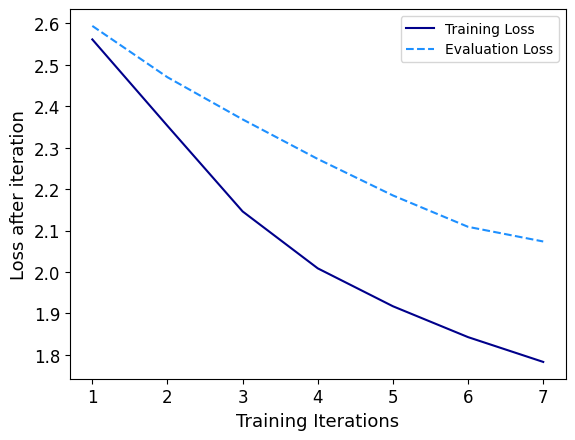

In [ ]:
# over  epochs
## plotting loss
import matplotlib.pyplot as plt

epochs = list(range(1,num_train_epochs+1))
name_to_save = "losses_bart_alt"


plt.plot(epochs, losses_per_epoch, color = "darkblue")
plt.plot(epochs, eval_losses_per_epoch, color = "dodgerblue", linestyle='dashed')
plt.legend(["Training Loss", "Evaluation Loss"], loc='upper right')
plt.xlabel("Training Iterations", fontsize=13)
plt.ylabel("Loss after iteration", fontsize=13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f'/content/gdrive/My Drive/Thesis/Plots/{name_to_save}.png')
plt.show()


In [ ]:
list_titles = []
name_save = "gen_titles_bart"

for i in range(len(list_titles), airbnb_london_filtered_advanced.shape[0]):
  print(i)
  gen_title = summarizer(airbnb_london_filtered_advanced.description[i], min_length=5, max_length=25)
  list_titles.append(gen_title[0]['summary_text'])
  if i % 500 == 0:
    list_titles_df = pd.DataFrame({"gen_titles": list_titles})
    list_titles_df.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_save}.csv", index = False)
  if i == airbnb_london_filtered_advanced.shape[0]:
    list_titles_df = pd.DataFrame({"gen_titles": list_titles})
    list_titles_df.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_save}.csv", index = False)

